# Tracking a Dynamic System (Learned Optimization)
In this notebook we will experiment with the data-aided learned optimizaiton. We will again consider the example of tracking a dynamic system, which we have already examined in the context of systems which are either purely model-based (Kalman filter) or data-driven (RNNs). We saw that each approach has its own pros and cons. Today we will explore the hybrid (though biased towards model-based) methodology of learned optimizaiton. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.linalg import sqrtm

## Data
To keep things simple, we again focus on the same state-space model as the one considered in the previous lectures, namely, the tracking of a moving object in 1D. Such settings correspond to a state-space model
\begin{align}
        {\boldsymbol s}_{t+1} &= {\boldsymbol F}{\boldsymbol s}_t + {\boldsymbol v}_t, \qquad {\boldsymbol v}_t\sim \mathcal{N}(0, {\boldsymbol{V}}), \\
        {\boldsymbol x}_t &=  {\boldsymbol H}{\boldsymbol s}_{t} +{\boldsymbol w}_t, \qquad {\boldsymbol w}_t\sim \mathcal{N}(0, {\boldsymbol{W}}).
\end{align}
Thus, the objective parameters are 
	\begin{equation} 
	    {\boldsymbol \theta}^{o} = \{{\boldsymbol F}, {\boldsymbol H}, {\boldsymbol V}, {\boldsymbol W}\}.
	\end{equation}

  Given ${\boldsymbol \psi} $, we can generate multiple trajectories (data samples) using the followig aid functions:

In [ ]:
def get_trajectory(trajectory_time, stateInit, F, H, V, W):
  position = []
  measurements = []
  # intiial state - zero position and constant velocity
  state = stateInit

  for t in trajectory_time: 
    state = np.dot(F, state) + np.dot(V,np.random.normal(size=(state.size,1))) 
    position.append(state.item(0))
    observation = np.dot(H, state) +   np.dot(W, np.random.normal(size=(H.shape[0],1)))
    measurements.append(observation.item(0)) 

  return torch.tensor([position]).T, torch.tensor([measurements]).T

In [ ]:
def gen_data(trajectory_time, stateInit, F, H, V, W, num_samples):
  data_set = []
  for sample in range(num_samples): 
    data_set.append((get_trajectory(trajectory_time, stateInit, F, H, V, W)))

  return data_set

We set the objective parameters following the model for 1D dynamics, where the state evolution model is
\begin{equation}
\boldsymbol{s}_{t+1}=\left[\begin{array}~1 & \Delta t \\ 0 & 1 \end{array} \right]\boldsymbol{s}_{t} +\boldsymbol{v}_t, \qquad \boldsymbol{v}_t \sim \mathcal{N}\left( 0, \boldsymbol{V} = \left[\begin{array}~\frac{1}{4}(\Delta t)^4 & \frac{1}{2}(\Delta t)^3 \\ \frac{1}{2}(\Delta t)^3 & (\Delta t)^2 \end{array} \right]\cdot \sigma_v^2\right).
\end{equation}
and the observation model is 
\begin{equation}
x_t = [1 \quad 0]\boldsymbol{s}_t + w_t, \qquad w_t \sim \mathcal{N}(0,\sigma_w^2).
\end{equation}

In [ ]:
dt = 0.1
sigma_v = 0.5

F = np.matrix([[1, dt],
               [0, 1]])

V = np.matrix([[(dt**4)/4, (dt**3)/2],
               [(dt**3)/2, dt**2]]) * sigma_v**2

H = np.matrix([[1, 0]])

sigma_w = 2*np.matrix([[1]])

We can now generate data including both train and test trajectories.

In [ ]:
trajectory_time = np.arange(0, 20, dt) 

stateInit =  np.array([[0], [1]]) 

train_data = gen_data(trajectory_time, stateInit, F, H, sqrtm(V), sigma_w, 20)
test_data = gen_data(trajectory_time, stateInit, F, H, sqrtm(V), sigma_w, 5)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

# Train and Validation 
Next, we formulate the training fucntion. 
We begin with defining an intermediate function for computing the accuracy of a given model over a dataset.

In [ ]:
def get_accuracy(model, data_loader):
    error, total = 0, 0
    criterion = nn.MSELoss()
    for position, measurements in data_loader:
        output = model(measurements) 
        error += criterion(output,position)
        total += 1
    return error / total

and the training function, which uses the Adam optimizer and the MSE loss.

In [ ]:
def train(model, train_loader,  num_epochs=5, learning_rate=1e-5):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_acc = []
    epochs = []
    # Loop over epochs
    for epoch in range(num_epochs):
        # Loop over batches
        for position, measurements in train_loader:
            optimizer.zero_grad()
            pred = model(measurements)
            loss = criterion(pred, position) 
            loss.backward(retain_graph=True)
            optimizer.step()
        # Save error on each epoch
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        print("Epoch %d;  Train MSE %f" % (
              epoch+1,  train_acc[-1]))


# Optimized Kalman Filter

next, we formulate the Kalman filter for this task as a trainable model. We specifically consider the case in which the statistics of the state driving noise ${\boldsymbol v}_t$ are unknown, and thus we set their covariance to be a *trainable parameter* of the system using the `nn.Parameter` syntex and clarify that it requires gradient computation with respect to. 

The remainder of the code is the same Kalman filter we used in the first lecture, only that here its forward path supports batches of trajectoties rather than single ones.

In [ ]:
# Kalman filter
class LearnedKalmanFilt(nn.Module):
    def __init__(self, F, H, V, W, StateInit):
        super(LearnedKalmanFilt, self).__init__()
  
        self.F = torch.tensor(F).float() 
        self.H = torch.tensor(H).float() 
        self.V = nn.Parameter(torch.tensor(V).float() )
        self.V.requires_grad=True
        self.W = torch.tensor(W).float() 

        # tracked sigma
        self.Sigma = torch.eye(self.F.shape[1]) 
        # tracked state
        self.s = torch.tensor(StateInit).float() 
        #self.s.requires_grad=True
        self.StateInit = torch.tensor(StateInit).float() 


    def predict(self):
        # Update time state
        self.s = torch.matmul(self.F, self.s) 

        # Calculate error covariance
        # Sigma= F*Sigma*F' + V
        tt = torch.matmul(self.F, self.Sigma)
        self.Sigma = torch.matmul(tt,self.F.T) + self.V
 

    def update(self, x):
        # S = H*P*H'+W
        S = torch.matmul(self.H, torch.matmul(self.Sigma, self.H.T)) + self.W

        # Calculate the Kalman Gain
        # K = Sigma * H'* inv(H*Sigma*H'+W)
        K = torch.matmul(torch.matmul(self.Sigma, self.H.T), torch.linalg.inv(S)) 

        self.s = (self.s + torch.matmul(K, (x - torch.matmul(self.H, self.s))))  

        I = torch.eye(self.H.shape[1])
        self.Sigma = torch.matmul((I - torch.matmul(K, self.H)), self.Sigma) 

    def forward(self, measurements_batch):                 
        batch_num = measurements_batch.shape[0]
        traj_len = measurements_batch.shape[1]
        predcition = torch.zeros((batch_num, traj_len, 1)).float() 
        for batch_idx, trajec in enumerate(measurements_batch): 
          local_predcition = torch.zeros(( traj_len, 1)).float()
          for t, x in enumerate(trajec):
            # First perdict next state without observation
            self.predict()
            # Then use observation to refine update
            self.update(x)
            # Return predicted position 
            local_predcition[t, :] = self.s[0] 
 
          # Return to initial state          
          self.s = self.StateInit 
          predcition[batch_idx, :, :] = local_predcition
        return predcition

Next, we apply two Kalman filter: 


1.   A system with *full domain knowledge*, whose performance represents the minimal achievable MSE (being the MSE optimal estimator for tracking in linear Gaussian state-space models).
2.   A system with *partial domain knolwedge*, which uses a mismatched covariance matrix for the state driving noise,



<ipython-input-9-2ad59f56ba60>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  VInit = torch.tensor(torch.eye(2), requires_grad=True)
<ipython-input-8-d8197dbcd771>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.V = nn.Parameter(torch.tensor(V).float() )


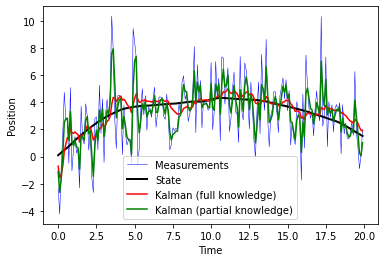

Full Knolwedge Test MSE: 0.238691
Partial Knowledge Test MSE: 1.587644


In [ ]:
VInit = torch.tensor(torch.eye(2), requires_grad=True)
# Selecting a specific trajectory in the test set to visualize
position, measurements = next(iter(test_loader))

# Kalman with full domain knowledge
kfFull = LearnedKalmanFilt(F, H, V, sigma_w , stateInit) 
predictionsFull = kfFull(measurements).detach().numpy()

# Kalman with patiral domain knowledge
kfPartial = LearnedKalmanFilt(F, H, VInit, sigma_w , stateInit)  
predictionsParital = kfPartial(measurements).detach().numpy()

fig = plt.figure()
plt.plot(trajectory_time, np.squeeze(measurements), label='Measurements', color='b',linewidth=0.5)
plt.plot(trajectory_time, np.squeeze(position), label='State', color='k', linewidth=2)
plt.plot(trajectory_time, np.squeeze(predictionsFull), label='Kalman (full knowledge)', color='r', linewidth=1.5)
plt.plot(trajectory_time, np.squeeze(predictionsParital), label='Kalman (partial knowledge)', color='g', linewidth=1.5)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Position', fontsize=10)
plt.legend()
plt.show() 

print("Full Knolwedge Test MSE: %f" % get_accuracy(kfFull, test_loader))
print("Partial Knowledge Test MSE: %f" % get_accuracy(kfPartial, test_loader))




Now, let's use data to fine tune the Kalman filter operating with partial domain knowledge

Epoch 1;  Train MSE 1.396727
Epoch 2;  Train MSE 1.238019
Epoch 3;  Train MSE 1.007416
Epoch 4;  Train MSE 0.498634
Epoch 5;  Train MSE 0.564253
Epoch 6;  Train MSE 0.502790
Epoch 7;  Train MSE 0.398778
Epoch 8;  Train MSE 0.306314
Epoch 9;  Train MSE 0.254937
Epoch 10;  Train MSE 0.235618


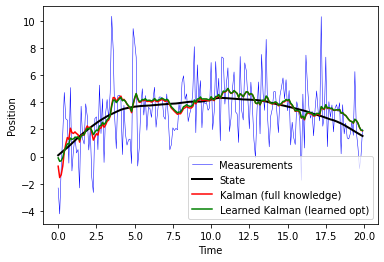

Full Knolwedge Test MSE: 0.238691
Partial Knowledge Test MSE: 0.243675


In [ ]:
# Train 
train(kfPartial, train_loader, num_epochs=10, learning_rate=1e-2)

# Switch to evaluation
kfPartial.eval()
predictions2 = kfPartial(measurements).detach().numpy()

fig = plt.figure()
plt.plot(trajectory_time, np.squeeze(measurements), label='Measurements', color='b',linewidth=0.5)
plt.plot(trajectory_time, np.squeeze(position), label='State', color='k', linewidth=2)
plt.plot(trajectory_time, np.squeeze(predictionsFull), label='Kalman (full knowledge)', color='r', linewidth=1.5)
plt.plot(trajectory_time, np.squeeze(predictions2), label='Learned Kalman (learned opt)', color='g', linewidth=1.5)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Position', fontsize=10)
plt.legend()
plt.show() 

# Compute test accuracy
print("Full Knolwedge Test MSE: %f" % get_accuracy(kfFull, test_loader))
print("Partial Knowledge Test MSE: %f" % get_accuracy(kfPartial, test_loader)) 